In [1]:
import tensorflow as tf
import bargo.datasets as datasets
import bargo.engine as engine
import bargo.utils as utils
import numpy as np
import matplotlib.pyplot as plt

import logging
import pickle
logging.getLogger("tensorflow").setLevel(logging.ERROR)

2024-03-18 18:22:10.208331: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


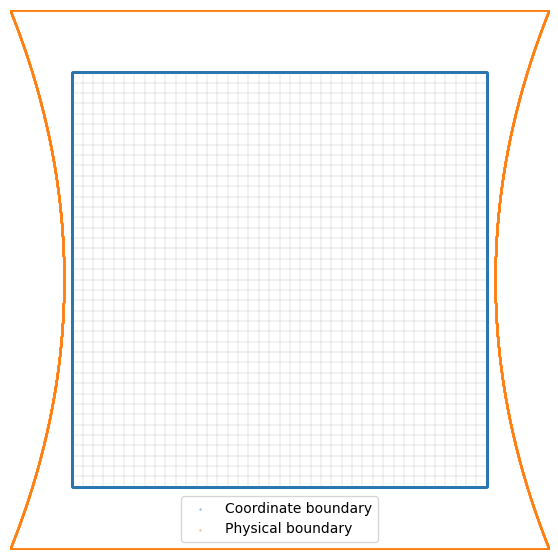

In [7]:
n = 10000
X = datasets.rectangle(n, 2, 2)
Y = np.array([[x + 0.2 * np.sign(x) * (y**2 - 1), y] for [x, y] in X]) * 1.3
grid = {'x0': -1, 'x1': 1, 'dx': 0.05, 'y0': -1, 'y1': 1, 'dy': 0.05}
grid = datasets.flat_grid(**grid)
fig, ax = utils.scatter([('Coordinate boundary', X), ('Physical boundary', Y)], grid, figsize=(7, 7))

In [4]:
N = 100
a = 1
h = 2 * a / (N - 1)

mesh = []
mask = []
for i in range(N):
    for j in range(N):
        x = -a + i * h
        y = -a + j * h
        mesh.append([x, y])
        mask.append(not (i==0 or j==0 or i==N-1 or j==N-1))

mask = np.reshape(mask, (N, N))
with open('data/run13/N100/mask.pkl', 'wb') as f:
    pickle.dump(mask, f)

In [4]:
args_hidden = {
    'units': 2,
    'activation': 'tanh',
    'kernel_initializer': 'ones',
    'bias_initializer': 'ones'
}
model = engine.NN.diffeomorphism(C=1, n_hidden_layers=5, **args_hidden)
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

2024-03-13 09:00:48.044440: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-03-13 09:00:48.045923: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-03-13 09:00:48.074851: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-13 09:00:48.075075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.83GHz coreCount: 30 deviceMemorySize: 5.78GiB deviceMemoryBandwidth: 312.97GiB/s
2024-03-13 09:00:48.075095: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-03-13 09:00:48.076726: I tensorflow/stream_executor/platform/def

In [5]:
loss_fn = engine.CustomLoss('mse')
trainer = engine.Trainer(model, loss_fn, opt)
trainer.prepare_data(X, Y, 0.2, 0.2, mesh)

In [7]:
trainer.fit(epochs=100000, patience=1000)

  0%|          | 0/100000 [00:00<?, ?it/s]2024-03-13 09:01:19.024689: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
train_loss: 1.678710e-06 val_boundary_loss: 8.864170e-07 eps: 1.0e-45 val_patience: 1001:   8%|▊         | 8487/100000 [02:25<26:06, 58.41it/s]

NO MORE PATIENCE


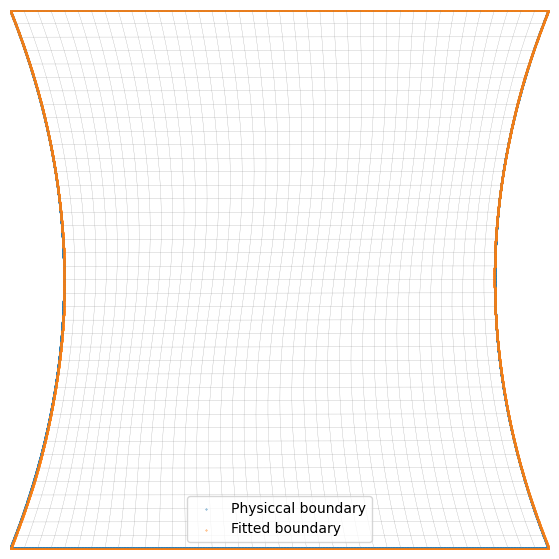

In [16]:
deformed_grid = []
for line in grid:
    deformed_line = model.predict(line, verbose=0)
    deformed_grid.append(deformed_line)

Y_pred = model.predict(X, verbose=0)
fig, ax = utils.scatter([('Physiccal boundary', Y), ('Fitted boundary', Y_pred)], deformed_grid, (7, 7))

In [15]:
trainer.loss_fn = engine.CustomLoss('tr_over_det')
trainer.loss_fn.eps = 1e-2
trainer.fit(epochs=100000, patience=1000)

train_loss: 3.389930e-06 val_boundary_loss: 2.211753e-06 eps: 1.0e-57 val_patience: 1001:   4%|▎         | 3733/100000 [34:09<14:40:49,  1.82it/s]


NO MORE PATIENCE


In [18]:
model.save('data/run13/model.keras')

In [6]:
engine.Geometry.push_forward(mesh, 'data/run13/N100')

2024-03-18 18:23:42.126607: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-03-18 18:23:42.127870: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-03-18 18:23:42.147296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-18 18:23:42.147530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.83GHz coreCount: 30 deviceMemorySize: 5.78GiB deviceMemoryBandwidth: 312.97GiB/s
2024-03-18 18:23:42.147559: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-03-18 18:23:42.149731: I tensorflow/stream_executor/platform/def

<tf.Variable 'Variable:0' shape=(10000, 2) dtype=float32, numpy=
array([[-1.        , -1.        ],
       [-1.        , -0.97979796],
       [-1.        , -0.959596  ],
       ...,
       [ 1.        ,  0.959596  ],
       [ 1.        ,  0.97979796],
       [ 1.        ,  1.        ]], dtype=float32)>


2024-03-18 18:23:42.718588: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-03-18 18:23:42.718630: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      0 
2024-03-18 18:23:42.718642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1280] 0:   N 
2024-03-18 18:23:42.718899: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-18 18:23:42.719144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-18 18:23:42.719357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-